# AirBnB Fair Valuation

Welcome to Airbnb Analysis Corp.! Your task is to set the competitive **daily accomodation rate** for a client's house in Bondi Beach. The owner currently charges $500. We have been tasked to estimate a **fair value** that the owner should be charging. The house has the following characteristics and constraints. While developing this model you came to realise that Airbnb can use your model to estimate the fair value of any property on their database, your are effectively creating a recommendation model for all prospective hosts!


1. The owner has been a host since **August 2010**
1. The location is **lon:151.274506, lat:33.889087**
1. The current review score rating **95.0**
1. Number of reviews **53**
1. Minimum nights **4**
1. The house can accomodate **10** people.
1. The owner currently charges a cleaning fee of **370**
1. The house has **3 bathrooms, 5 bedrooms, 7 beds**.
1. The house is available for **255 of the next 365 days**
1. The client is **verified**, and they are a **superhost**.
1. The cancelation policy is **strict with a 14 days grace period**.
1. The host requires a security deposit of **$1,500**


*All values strictly apply to the month of July 2018*

In [1]:
# Defining our Sample Client Data
from dateutil import parser
dict_client = {}

dict_client["city"] = "Bondi Beach"
dict_client["longitude"] = 151.274506
dict_client["latitude"] = -33.889087
dict_client["review_scores_rating"] = 95
dict_client["number_of_reviews"] = 53
dict_client["minimum_nights"] = 4
dict_client["accommodates"] = 10
dict_client["bathrooms"] = 3
dict_client["bedrooms"] = 5
dict_client["beds"] = 7
dict_client["security_deposit"] = 1500
dict_client["cleaning_fee"] = 370
dict_client["property_type"] = "House"
dict_client["room_type"] = "Entire home/apt"
dict_client["availability_365"] = 255
dict_client["host_identity_verified"] = 't'  ## 1 for yes, 0 for no
dict_client["host_is_superhost"] = 't'
dict_client["cancellation_policy"] = "strict_14_with_grace_period"
dict_client["host_since"] = parser.parse("01-08-2010")

In [ ]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals
# Common imports
import numpy as np
import os
import pandas as pd
from pathlib import Path
import re
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [2]:
# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    try:
        plt.savefig(path, format=fig_extension, dpi=resolution)
    except:
        plt.savefig(fig_id + "." + fig_extension, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
pd.options.display.max_columns = None

# Get the data

In [3]:

github_p = "https://raw.githubusercontent.com/Finance-781/FinML/master/Lecture%202%20-%20End-to-End%20ML%20Project%20/Practice/"

my_file = Path("datasets/sydney_airbnb.csv") # Defines path
if my_file.is_file():              # See if file exists
    print("Local file found")      
    df = pd.read_csv('datasets/sydney_airbnb.csv')
else:
    print("Be patient: loading from github (2 minutes)")
    df = pd.read_csv(github_p+'datasets/sydney_airbnb.csv')
    print("Done")

Be patient: loading from github (2 minutes)
Done


C:\Users\Atena\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (36,54,55) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
df.head()

,id,listing_url,name,summary,space,description,neighborhood_overview,notes,transit,access,interaction,house_rules,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,11156,https://www.airbnb.com/rooms/11156,An Oasis in the City,Very central to the city which can be reached ...,Potts Pt. is a vibrant and popular inner-city...,Very central to the city which can be reached ...,"It is very close to everything and everywhere,...","$150.00 key security deposit, refundable on re...",It is 7 minutes walk to the Kings Cross.train ...,Kitchen & laundry facilities. Shared bathroom.,As much as they want.,Be considerate. No showering after 2330h.,https://a0.muscache.com/im/pictures/2797669/17...,40855,https://www.airbnb.com/users/show/40855,Colleen,23/09/09,"Potts Point, New South Wales, Australia","Recently retired, I've lived & worked on 4 con...",within a day,67%,t,https://a0.muscache.com/im/users/40855/profile...,https://a0.muscache.com/im/users/40855/profile...,Potts Point,1.0,1.0,"['email', 'phone', 'reviews']",t,f,"Potts Point, NSW, Australia",Potts Point,Sydney,NaN,Potts Point,NSW,2011,Sydney,"Potts Point, Australia",AU,Australia,-33.869168,151.226562,t,Apartment,Private room,1,NaN,1.0,1.0,Real Bed,"{TV,Kitchen,Elevator,""Buzzer/wireless intercom...",NaN,$65.00,NaN,NaN,NaN,NaN,1,$0.00,2,180,4 weeks ago,t,9,39,69,339,177,5/12/09,1/07/18,92.0,9.0,9.0,10.0,10.0,10.0,9.0,f,moderate,f,f,1,1.69
1,12351,https://www.airbnb.com/rooms/12351,Sydney City & Harbour at the door,Come stay with Vinh & Stuart (Awarded as one o...,"We're pretty relaxed hosts, and we fully appre...",Come stay with Vinh & Stuart (Awarded as one o...,"Pyrmont is an inner-city village of Sydney, on...",We've a few reasons for the 6.00pm arrival tim...,Our home is centrally located and an easy walk...,We look forward to welcoming you just as we wo...,As much or as little as you like. We live here...,We look forward to welcoming you to stay you j...,https://a0.muscache.com/im/pictures/763ad5c8-c...,17061,https://www.airbnb.com/users/show/17061,Stuart,14/05/09,"Sydney, New South Wales, Australia","G'Day from Australia!\r\n\r\nHe's Vinh, and I'...",within an hour,100%,f,https://a0.muscache.com/im/users/17061/profile...,https://a0.muscache.com/im/users/17061/profile...,Pyrmont,2.0,2.0,"['email', 'phone', 'manual_online', 'reviews',...",t,t,"Pyrmont, NSW, Australia",Pyrmont,Sydney,NaN,Pyrmont,NSW,2009,Sydney,"Pyrmont, Australia",AU,Australia,-33.865153,151.191896,t,Townhouse,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",""Paid par...",NaN,$98.00,$800.00,NaN,$0.00,$55.00,2,$395.00,2,7,yesterday,t,13,30,45,188,468,24/07/10,27/06/18,95.0,10.0,9.0,10.0,10.0,10.0,10.0,f,strict_14_with_grace_period,t,t,2,4.83
2,14250,https://www.airbnb.com/rooms/14250,Manly Harbour House,"Beautifully renovated, spacious and quiet, our...",Our home is a thirty minute walk along the sea...,"Beautifully reno

In [5]:
### We select only a small number of features as the others we can discard for this study

In [6]:
incl = ["price","city","longitude","latitude","review_scores_rating","number_of_reviews","minimum_nights","security_deposit","cleaning_fee",
        "accommodates","bathrooms","bedrooms","beds","property_type","room_type","availability_365" ,"host_identity_verified", 
        "host_is_superhost","host_since","cancellation_policy"] 

df = df[incl]

In [7]:
df.head()

,price,city,longitude,latitude,review_scores_rating,number_of_reviews,minimum_nights,security_deposit,cleaning_fee,accommodates,bathrooms,bedrooms,beds,property_type,room_type,availability_365,host_identity_verified,host_is_superhost,host_since,cancellation_policy
0,$65.00,Potts Point,151.226562,-33.869168,92.0,177,2,NaN,NaN,1,NaN,1.0,1.0,Apartment,Private room,339,f,t,23/09/09,moderate
1,$98.00,Pyrmont,151.191896,-33.865153,95.0,468,2,$0.00,$55.00,2,1.0,1.0,1.0,Townhouse,Private room,188,t,f,14/05/09,strict_14_with_grace_period
2,$469.00,Balgowlah,151.261722,-33.800929,100.0,1,5,$900.00,$100.00,6,3.0,3.0,3.0,House,Entire home/apt,168,t,f,20/11/09,strict_14_with_grace_period
3,$63.00,Redfern,151.200450,-33.890765,89.0,172,2,NaN,NaN,2,1.0,1.0,1.0,Apartment,Private room,215,t,f,30/11/09,moderate
4,$39.00,Redfern,151.200896,-33.889667,90.0,147,2,NaN,NaN,1,2.0,1.0,1.0,Apartment,Shared room,287,t,f,30/11/09,moderate


In [8]:
df.shape

(27070, 20)

The price field currently has the "$" in it and is a string. So lets remove it and convert it to a float datatype.

Also lets conver the 'host_since' field to a date time format. 

In [9]:

# The price fields in our data frame
price_list = ["price","cleaning_fee","security_deposit"]

# We change any blanks to 0 and use our regex function to remove anything that isn't a number (or negative number which is changed to 0)
for col in price_list:
    df[col] = df[col].fillna("0")
    df[col] = df[col].apply(lambda x: float(re.compile('[^0-9eE.]').sub('', x)) if len(x)>0 else 0)

df['host_since'] = pd.to_datetime(df['host_since'])

In [10]:
# Let's see if it worked
df["price"].head()

0     65.0
1     98.0
2    469.0
3     63.0
4     39.0
Name: price, dtype: float64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27070 entries, 0 to 27069
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   price                   27070 non-null  float64       
 1   city                    27037 non-null  object        
 2   longitude               27070 non-null  float64       
 3   latitude                27070 non-null  float64       
 4   review_scores_rating    19512 non-null  float64       
 5   number_of_reviews       27070 non-null  int64         
 6   minimum_nights          27070 non-null  int64         
 7   security_deposit        27070 non-null  float64       
 8   cleaning_fee            27070 non-null  float64       
 9   accommodates            27070 non-null  int64         
 10  bathrooms               27048 non-null  float64       
 11  bedrooms                27062 non-null  float64       
 12  beds                    27037 non-null  float6

<AxesSubplot:ylabel='price'>

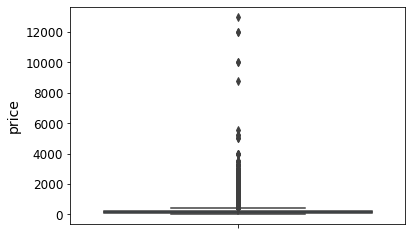

In [12]:
## Use a boxplot to check for high price values (outliers)

sns.boxplot( y=df["price"] )

In [13]:
# We can see a few high value pries, with the majority being close to bottom (seems like ~100-200)

# We now use skew to check for the symmetry of the data distribution (0 being perfectly symmetrical)
# https://www.spcforexcel.com/knowledge/basic-statistics/are-skewness-and-kurtosis-useful-statistics
df["price"].skew()

13.808558337216192

In [14]:
# We can also use Kurtosis to analyze our data
# “Kurtosis is the degree of peakedness of a distribution” – Wolfram MathWorld

df["price"].kurtosis()

413.4301463784445

In [15]:
## So in order to remove or filter out our high value 'outliers' let's consider taking our data from the 99.5% percentile and exclude the bottom .25% and top 0.25% of prices
## This function returns the highest value of the 99.5% percentile which is still relatively high when compared to the mean and median
print(df["price"].quantile(0.995))
print(df["price"].mean())
print(df["price"].median())

1600.0
209.27879571481344
135.0


In [16]:
# Now we remove all prices over the 99.5% percentile (or in order words, we keep all data rows under the 99.5% value of 1600)
df = df[df["price"]<df["price"].quantile(0.995)].reset_index(drop=True)

In [17]:
# Let's check our skew now
df["price"].skew()

2.957872457159033

In [18]:
# Let's check our data for null values
df.isnull().sum()

price                        0
city                        32
longitude                    0
latitude                     0
review_scores_rating      7466
number_of_reviews            0
minimum_nights               0
security_deposit             0
cleaning_fee                 0
accommodates                 0
bathrooms                   22
bedrooms                     8
beds                        33
property_type                0
room_type                    0
availability_365             0
host_identity_verified      34
host_is_superhost           34
host_since                  34
cancellation_policy          0
dtype: int64

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26931 entries, 0 to 26930
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   price                   26931 non-null  float64       
 1   city                    26899 non-null  object        
 2   longitude               26931 non-null  float64       
 3   latitude                26931 non-null  float64       
 4   review_scores_rating    19465 non-null  float64       
 5   number_of_reviews       26931 non-null  int64         
 6   minimum_nights          26931 non-null  int64         
 7   security_deposit        26931 non-null  float64       
 8   cleaning_fee            26931 non-null  float64       
 9   accommodates            26931 non-null  int64         
 10  bathrooms               26909 non-null  float64       
 11  bedrooms                26923 non-null  float64       
 12  beds                    26898 non-null  float6

In [20]:
print(df["cancellation_policy"].value_counts())
print(df["city"].value_counts())
print(df["property_type"].value_counts())
print(df["room_type"].value_counts())

strict_14_with_grace_period    11585
flexible                        8538
moderate                        6776
super_strict_60                   31
super_strict_30                    1
Name: cancellation_policy, dtype: int64
Bondi Beach                         1671
Manly                                958
Surry Hills                          919
Bondi                                785
Randwick                             684
                                    ... 
Hassall Grove                          1
Bronte                                 1
Northern Beaches                       1
Hurstville Sydney                      1
Gladesville, New South Wales, AU       1
Name: city, Length: 741, dtype: int64
Apartment                 15901
House                      7722
Townhouse                  1145
Condominium                 351
Guest suite                 350
Guesthouse                  287
Villa                       201
Loft                        175
Bed and breakfast           15

In [21]:
df.describe()

,price,longitude,latitude,review_scores_rating,number_of_reviews,minimum_nights,security_deposit,cleaning_fee,accommodates,bathrooms,bedrooms,beds,availability_365
count,26931.000000,26931.000000,26931.000000,19465.000000,26931.000000,26931.000000,26931.000000,26931.000000,26931.000000,26909.000000,26923.000000,26898.000000,26931.000000
mean,196.065464,151.210438,-33.862675,93.404932,14.070031,4.482010,293.870261,65.268687,3.357395,1.340964,1.600787,1.996542,101.575916
std,199.813830,0.079425,0.071861,9.358515,29.870227,14.421896,549.642202,84.886663,2.160004,0.638187,1.091213,1.506535,127.822623
min,0.000000,150.644964,-34.135212,20.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,80.000000,151.184336,-33.897653,90.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,0.000000
50%,132.000000,151.223029,-33.883161,96.000000,3.000000,2.000000,0.000000,40.000000,2.000000,1.000000,1.000000,1.000000,32.000000
75%,225.000000,151.264706,-33.832189,100.000000,13.000000,5.000000,400.000000,99.000000,4.000000,1.500000,2.000000,2.000000,179.000000
max,1599.000000,151.339811,-33.389728,100.000000,468.000000,1000.000000,7000.000000,999.000000,16.000000,10.000000,46.000000,29.000000,365.000000


Saving figure attribute_histogram_plots


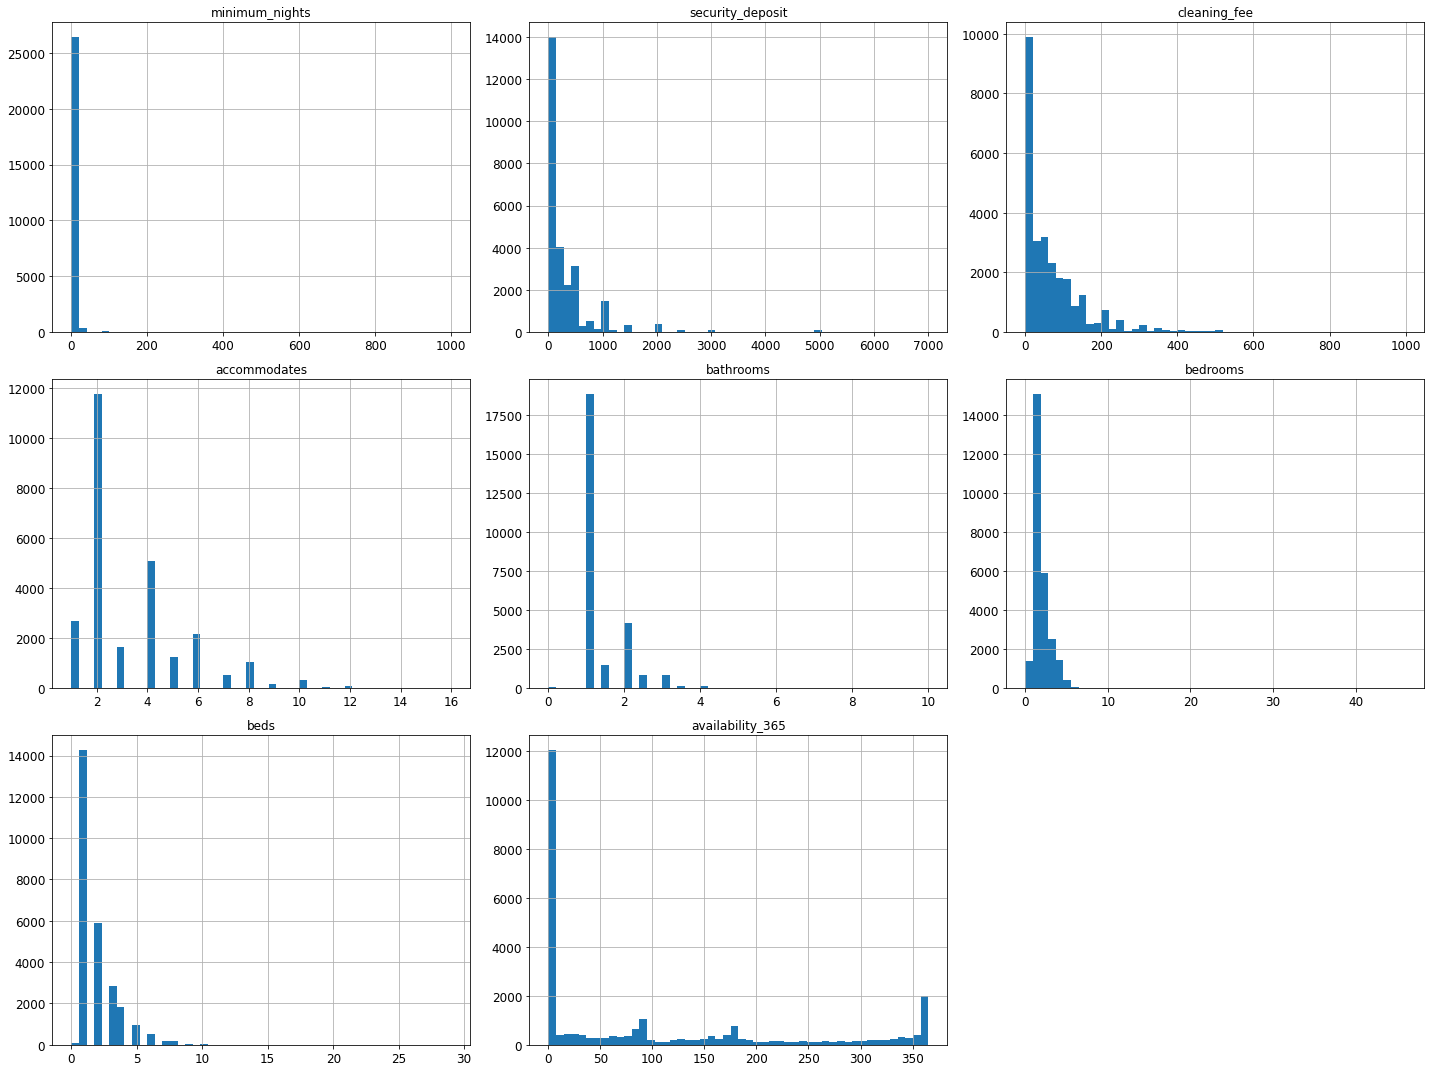

In [22]:
# Data Exploration - Let's explore 

try:
    # We select all rows and all columns after the 6th
    df.iloc[:,6:].hist(bins=50, figsize=(20,15))
    save_fig("attribute_histogram_plots")
    plt.show()
except AttributeError:
    pass


In [23]:
## We keep all the city types to create our model (more is data usually better), even though our customer, sepecifcally wants information about Bondi Beach 

df["city"].value_counts().head(10)

Bondi Beach     1671
Manly            958
Surry Hills      919
Bondi            785
Randwick         684
Sydney           682
Coogee           675
Darlinghurst     660
North Bondi      629
Newtown          490
Name: city, dtype: int64

In [24]:
## For this taks we will keep the top 20 Sydney locations

list_of_20 = list(df["city"].value_counts().head(10).index)
df = df[df["city"].isin(list_of_20)].reset_index(drop=True)

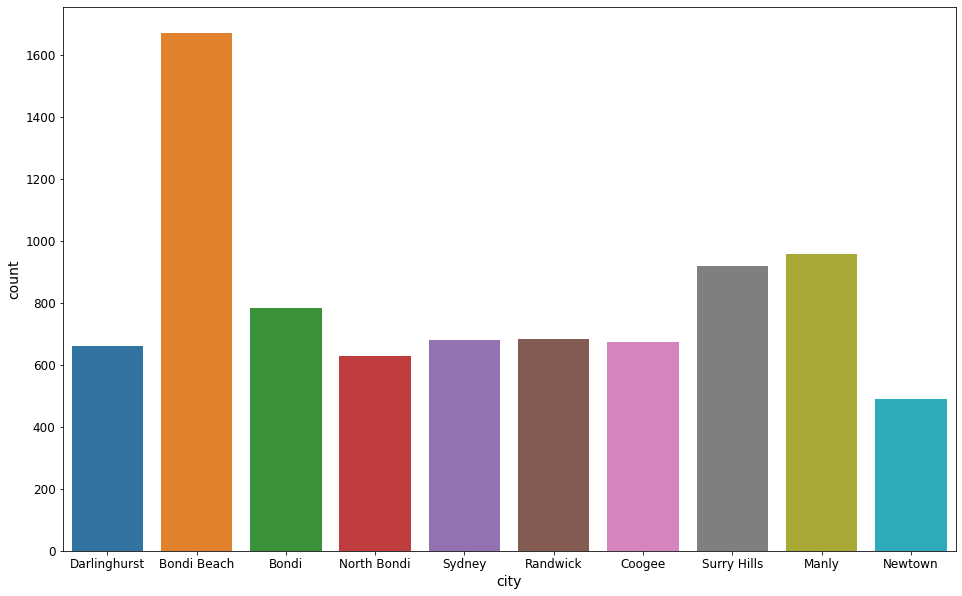

In [25]:
plt.figure(figsize=(16,10))
ax = sns.countplot(x="city", data=df)

In [26]:
df["property_type"].value_counts()

Apartment             5970
House                 1497
Townhouse              271
Condominium            115
Loft                    59
Guest suite             44
Other                   33
Hostel                  30
Bed and breakfast       25
Guesthouse              24
Serviced apartment      23
Villa                   16
Bungalow                 7
Tent                     6
Cottage                  6
Boutique hotel           6
Resort                   5
Tiny house               5
Hotel                    3
Cabin                    2
Camper/RV                1
Aparthotel               1
Houseboat                1
Earth house              1
Yurt                     1
Chalet                   1
Name: property_type, dtype: int64

In [27]:
# We now remove the rare occurences in categories as it's necessary for the cross validation step
# the below step is somewhat similar for what has been done with cities above

# We store the counts of each type in the variable item_counts
item_counts = df.groupby(['property_type']).size()

# Store a list of the rare property types here i.e. the types that have a count less than 10 
rare_items = list(item_counts.loc[item_counts <= 10].index.values)

# drop the property types that were rare
df = df[~df["property_type"].isin(rare_items)].reset_index(drop=True)

# Sanity check
df["property_type"].value_counts()

Apartment             5970
House                 1497
Townhouse              271
Condominium            115
Loft                    59
Guest suite             44
Other                   33
Hostel                  30
Bed and breakfast       25
Guesthouse              24
Serviced apartment      23
Villa                   16
Name: property_type, dtype: int64

In [28]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [29]:
test_set.head()

,price,city,longitude,latitude,review_scores_rating,number_of_reviews,minimum_nights,security_deposit,cleaning_fee,accommodates,bathrooms,bedrooms,beds,property_type,room_type,availability_365,host_identity_verified,host_is_superhost,host_since,cancellation_policy
4084,68.0,North Bondi,151.279684,-33.884092,93.0,3,7,150.0,0.0,2,2.5,1.0,1.0,House,Private room,4,t,f,2016-08-18,strict_14_with_grace_period
965,128.0,Surry Hills,151.212610,-33.891416,100.0,4,5,690.0,99.0,4,1.0,2.0,2.0,Townhouse,Entire home/apt,173,t,t,2014-10-31,moderate
8100,115.0,Darlinghurst,151.217882,-33.874271,98.0,8,2,0.0,30.0,3,1.0,1.0,1.0,Apartment,Entire home/apt,12,f,f,2017-04-02,moderate
3882,125.0,Sydney,151.204837,-33.875924,NaN,0,2,150.0,50.0,4,1.0,1.0,3.0,Other,Shared room,363,f,f,2014-12-01,flexible
1010,250.0,North Bondi,151.274298,-33.885652,100.0,4,2,0.0,80.0,2,1.0,1.0,1.0,Apartment,Entire home/apt,363,t,f,2012-09-29,strict_14_with_grace_period


In [30]:
##  Similar to above encoding, here we encode binary 1, 0 for t and f. 

df["host_identity_verified"] = df["host_identity_verified"].apply(lambda x: 1 if x=="t" else 0)
df["host_is_superhost"] = df["host_is_superhost"].apply(lambda x: 1 if x=="t" else 0)

In [31]:
# We need to convert our categorical columns to numeric, so we use the sklearn's funtion LabelEncoder to do this
le = preprocessing.LabelEncoder()

for col in ["city"]:
    df[col+"_code"] = le.fit_transform(df[col])

In [32]:
df.head()

,price,city,longitude,latitude,review_scores_rating,number_of_reviews,minimum_nights,security_deposit,cleaning_fee,accommodates,bathrooms,bedrooms,beds,property_type,room_type,availability_365,host_identity_verified,host_is_superhost,host_since,cancellation_policy,city_code
0,111.0,Darlinghurst,151.216541,-33.880455,88.0,272,2,0.0,0.0,2,1.0,1.0,1.0,Apartment,Private room,285,1,0,2009-03-12,strict_14_with_grace_period,3
1,700.0,Bondi Beach,151.274506,-33.889087,95.0,53,4,1500.0,370.0,11,3.0,5.0,7.0,House,Entire home/apt,255,1,1,2010-08-14,strict_14_with_grace_period,1
2,190.0,Bondi,151.271029,-33.897393,94.0,12,2,500.0,150.0,4,1.0,2.0,3.0,Apartment,Entire home/apt,233,1,0,2010-04-26,strict_14_with_grace_period,0
3,225.0,North Bondi,151.283553,-33.889633,79.0,16,2,500.0,130.0,4,1.0,2.0,2.0,Apartment,Entire home/apt,152,1,0,2010-04-26,strict_14_with_grace_period,6
4,130.0,Bondi Beach,151.273084,-33.891846,95.0,119,4,200.0,60.0,2,1.0,1.0,1.0,Apartment,Entire home/apt,94,1,1,2012-01-18,strict_14_with_grace_period,1


### Stratified Shuffle Split cross-validator

Provides train/test indices to split data in train/test sets.

This cross-validation object is a merge of StratifiedKFold and ShuffleSplit, which returns stratified randomized folds. The folds are made by preserving the percentage of samples for each class.

In [33]:
## we will stratify according to city

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["city_code"]):
    del df["city_code"]
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [34]:
## Average price per area
strat_test_set.groupby("city")["price"].mean()

city
Bondi           198.745223
Bondi Beach     199.879880
Coogee          196.574627
Darlinghurst    184.700000
Manly           223.447368
Newtown         117.938776
North Bondi     248.857143
Randwick        178.072993
Surry Hills     175.732240
Sydney          193.962687
Name: price, dtype: float64

# Further Data Exploration and Visualization

In [35]:
traval = strat_train_set.copy() ##traval - training and validation set

Saving figure bad_visualization_plot


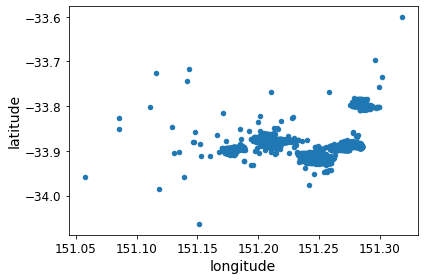

In [36]:
# Let's plot our cordinates which is a way of visualizing a map of the locations

traval.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

Saving figure better_visualization_plot


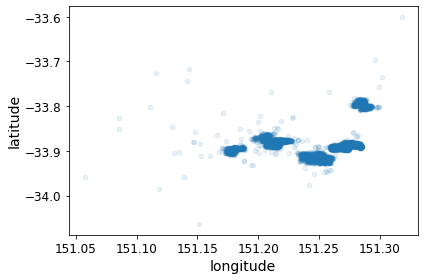

In [37]:
traval.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("better_visualization_plot")

In [38]:
# Let's narrow our visual map and remove locations outside the main area
traval_co = traval[(traval["longitude"]>151.16)&(traval["latitude"]<-33.75)].reset_index(drop=True)

traval_co = traval_co[traval_co["latitude"]>-33.95].reset_index(drop=True)

# And only look at locations under $600
traval_co = traval_co[traval_co["price"]<600].reset_index(drop=True)

The argument `sharex=False` fixes a display bug (the x-axis values and legend were not displayed). This is a temporary fix (see: https://github.com/pandas-dev/pandas/issues/10611). Thanks to Wilmer Arellano for pointing it out.

Saving figure housing_prices_scatterplot


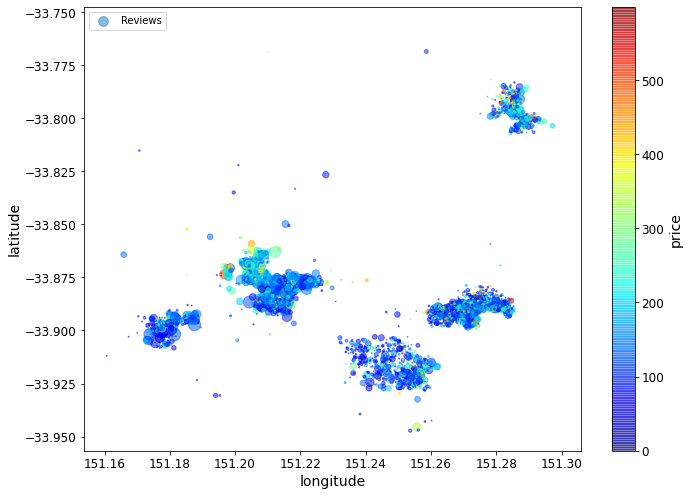

In [39]:
traval_co.plot(kind="scatter", x="longitude", y="latitude", alpha=0.5,
    s=traval_co["number_of_reviews"]/2, label="Reviews", figsize=(10,7),
    c="price", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

In [40]:
traval_co.shape

(6230, 20)

Text(0.5, 1.0, 'Heatmap of Correlation Matrix')

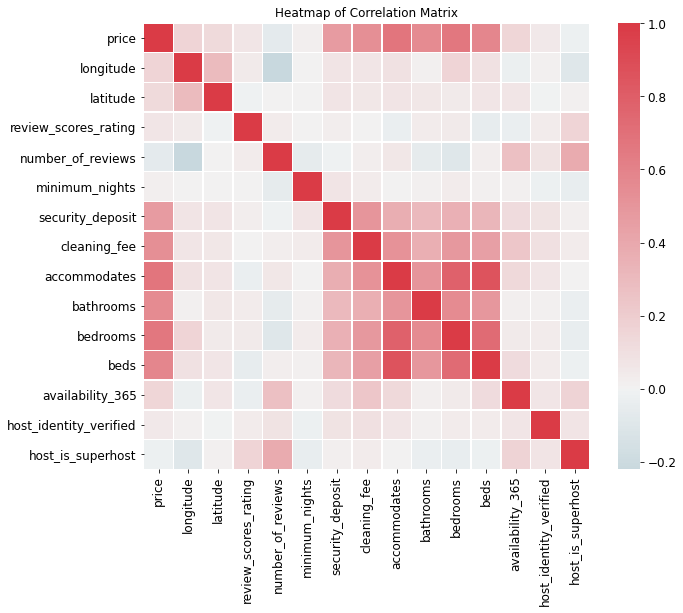

In [41]:
# Now let's explore our correlation matrix

corr_matrix = traval.corr()

# Heatmap
plt.figure(figsize = (10,10))
cmap = sns.diverging_palette(220,10,as_cmap = True)

#Deep dive into diverging_pattern
sns.heatmap(corr_matrix, xticklabels=corr_matrix.columns.values,
           yticklabels=corr_matrix.columns.values, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .82})
plt.title('Heatmap of Correlation Matrix')

In [42]:
corr_matrix["price"].sort_values(ascending=False)

price                     1.000000
accommodates              0.674368
bedrooms                  0.668963
beds                      0.582378
bathrooms                 0.553773
cleaning_fee              0.529834
security_deposit          0.469423
longitude                 0.157902
availability_365          0.148263
latitude                  0.131160
review_scores_rating      0.067066
host_identity_verified    0.048821
minimum_nights            0.022103
host_is_superhost        -0.016695
number_of_reviews        -0.064011
Name: price, dtype: float64

Saving figure scatter_matrix_plot


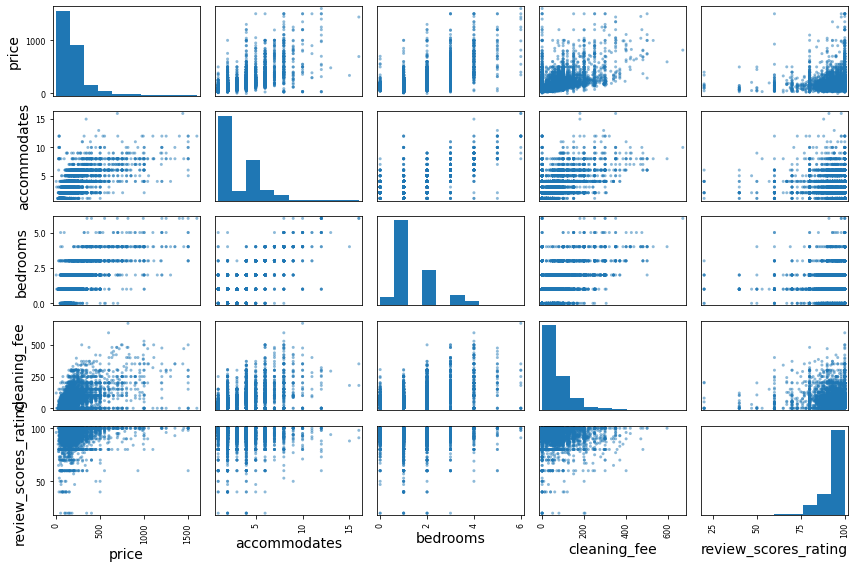

In [43]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas


attributes = ["price", "accommodates", "bedrooms",
              "cleaning_fee","review_scores_rating"]
scatter_matrix(traval[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

Saving figure income_vs_house_value_scatterplot


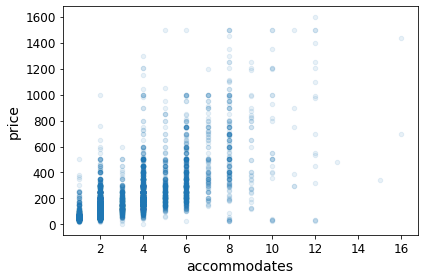

In [44]:
traval.plot(kind="scatter", x="accommodates", y="price", alpha=0.1)
save_fig("income_vs_house_value_scatterplot")

In [45]:
traval.head()

,price,city,longitude,latitude,review_scores_rating,number_of_reviews,minimum_nights,security_deposit,cleaning_fee,accommodates,bathrooms,bedrooms,beds,property_type,room_type,availability_365,host_identity_verified,host_is_superhost,host_since,cancellation_policy
5484,200.0,Newtown,151.178552,-33.907150,96.0,61,2,250.0,85.0,4,1.0,2.0,2.0,House,Entire home/apt,127,1,0,2016-01-22,moderate
1267,183.0,Randwick,151.249030,-33.906190,97.0,6,4,0.0,20.0,2,1.0,1.0,1.0,Apartment,Private room,0,1,0,2014-03-28,moderate
6658,175.0,Manly,151.288491,-33.802074,100.0,2,2,0.0,40.0,2,1.0,1.0,1.0,Apartment,Entire home/apt,0,1,0,2014-01-09,strict_14_with_grace_period
2522,85.0,Randwick,151.236423,-33.913614,94.0,20,3,0.0,0.0,2,1.0,1.0,1.0,Apartment,Private room,90,0,0,2015-11-22,flexible
722,80.0,Coogee,151.259342,-33.918435,92.0,139,30,0.0,0.0,3,1.0,1.0,2.0,Apartment,Private room,0,1,0,2014-01-07,strict_14_with_grace_period


In [46]:
#### Now let's create some new features

traval["bedrooms_per_person"] = traval["bedrooms"]/traval["accommodates"]
traval["bathrooms_per_person"] = traval["bathrooms"]/traval["accommodates"]
traval['host_since'] = pd.to_datetime(traval['host_since'])
traval['days_on_airbnb'] = (pd.to_datetime('today') - traval['host_since']).dt.days

In [47]:
traval.head()

,price,city,longitude,latitude,review_scores_rating,number_of_reviews,minimum_nights,security_deposit,cleaning_fee,accommodates,bathrooms,bedrooms,beds,property_type,room_type,availability_365,host_identity_verified,host_is_superhost,host_since,cancellation_policy,bedrooms_per_person,bathrooms_per_person,days_on_airbnb
5484,200.0,Newtown,151.178552,-33.907150,96.0,61,2,250.0,85.0,4,1.0,2.0,2.0,House,Entire home/apt,127,1,0,2016-01-22,moderate,0.500000,0.250000,1831.0
1267,183.0,Randwick,151.249030,-33.906190,97.0,6,4,0.0,20.0,2,1.0,1.0,1.0,Apartment,Private room,0,1,0,2014-03-28,moderate,0.500000,0.500000,2496.0
6658,175.0,Manly,151.288491,-33.802074,100.0,2,2,0.0,40.0,2,1.0,1.0,1.0,Apartment,Entire home/apt,0,1,0,2014-01-09,strict_14_with_grace_period,0.500000,0.500000,2574.0
2522,85.0,Randwick,151.236423,-33.913614,94.0,20,3,0.0,0.0,2,1.0,1.0,1.0,Apartment,Private room,90,0,0,2015-11-22,flexible,0.500000,0.500000,1892.0
722,80.0,Coogee,151.259342,-33.918435,92.0,139,30,0.0,0.0,3,1.0,1.0,2.0,Apartment,Private room,0,1,0,2014-01-07,strict_14_with_grace_period,0.333333,0.333333,2576.0


# Prepare the data for Machine Learning algorithms

In [48]:
## Here I will forget about traval and use a more formal way of introducing...
## ..preprocessing using pipelines

In [49]:
# Firstly we remove our price (or labels from our travel dataset)
X  = traval.copy().drop("price", axis=1) # drop labels for training set

In [50]:
# Show the rows of data with missing values

sample_incomplete_rows = X[X.isnull().any(axis=1)].head()
print(sample_incomplete_rows.shape)
sample_incomplete_rows

(5, 22)


,city,longitude,latitude,review_scores_rating,number_of_reviews,minimum_nights,security_deposit,cleaning_fee,accommodates,bathrooms,bedrooms,beds,property_type,room_type,availability_365,host_identity_verified,host_is_superhost,host_since,cancellation_policy,bedrooms_per_person,bathrooms_per_person,days_on_airbnb
5594,Randwick,151.238806,-33.913834,NaN,0,2,800.0,80.0,6,1.0,3.0,3.0,House,Entire home/apt,0,0,0,2013-11-27,moderate,0.500000,0.166667,2617.0
5439,Newtown,151.184469,-33.894582,NaN,0,3,5000.0,100.0,11,2.0,3.0,4.0,Apartment,Entire home/apt,0,1,0,2014-07-16,strict_14_with_grace_period,0.272727,0.181818,2386.0
3847,Bondi Beach,151.273077,-33.895142,NaN,0,7,271.0,27.0,2,1.0,1.0,1.0,Apartment,Private room,0,0,0,2015-12-07,strict_14_with_grace_period,0.500000,0.500000,1877.0
1312,Randwick,151.245793,-33.920622,NaN,0,3,0.0,80.0,3,1.0,2.0,2.0,Apartment,Entire home/apt,0,0,0,2015-10-02,strict_14_with_grace_period,0.666667,0.333333,1943.0
6194,Bondi Beach,151.273411,-33.888113,NaN,0,10,0.0,0.0,2,1.0,1.0,1.0,Apartment,Private room,0,1,0,2015-08-14,moderate,0.500000,0.500000,1992.0


In [51]:
# Rows Remove
sample_incomplete_rows.dropna(subset=["review_scores_rating"])    # option 1

,city,longitude,latitude,review_scores_rating,number_of_reviews,minimum_nights,security_deposit,cleaning_fee,accommodates,bathrooms,bedrooms,beds,property_type,room_type,availability_365,host_identity_verified,host_is_superhost,host_since,cancellation_policy,bedrooms_per_person,bathrooms_per_person,days_on_airbnb


In [52]:
# Columns Remove
sample_incomplete_rows.drop(["review_scores_rating"], axis=1)       # option 2

,city,longitude,latitude,number_of_reviews,minimum_nights,security_deposit,cleaning_fee,accommodates,bathrooms,bedrooms,beds,property_type,room_type,availability_365,host_identity_verified,host_is_superhost,host_since,cancellation_policy,bedrooms_per_person,bathrooms_per_person,days_on_airbnb
5594,Randwick,151.238806,-33.913834,0,2,800.0,80.0,6,1.0,3.0,3.0,House,Entire home/apt,0,0,0,2013-11-27,moderate,0.500000,0.166667,2617.0
5439,Newtown,151.184469,-33.894582,0,3,5000.0,100.0,11,2.0,3.0,4.0,Apartment,Entire home/apt,0,1,0,2014-07-16,strict_14_with_grace_period,0.272727,0.181818,2386.0
3847,Bondi Beach,151.273077,-33.895142,0,7,271.0,27.0,2,1.0,1.0,1.0,Apartment,Private room,0,0,0,2015-12-07,strict_14_with_grace_period,0.500000,0.500000,1877.0
1312,Randwick,151.245793,-33.920622,0,3,0.0,80.0,3,1.0,2.0,2.0,Apartment,Entire home/apt,0,0,0,2015-10-02,strict_14_with_grace_period,0.666667,0.333333,1943.0
6194,Bondi Beach,151.273411,-33.888113,0,10,0.0,0.0,2,1.0,1.0,1.0,Apartment,Private room,0,1,0,2015-08-14,moderate,0.500000,0.500000,1992.0


In [53]:
median = X["review_scores_rating"].median()
sample_incomplete_rows["review_scores_rating"].fillna(median, inplace=True) # option 3

sample_incomplete_rows

,city,longitude,latitude,review_scores_rating,number_of_reviews,minimum_nights,security_deposit,cleaning_fee,accommodates,bathrooms,bedrooms,beds,property_type,room_type,availability_365,host_identity_verified,host_is_superhost,host_since,cancellation_policy,bedrooms_per_person,bathrooms_per_person,days_on_airbnb
5594,Randwick,151.238806,-33.913834,96.0,0,2,800.0,80.0,6,1.0,3.0,3.0,House,Entire home/apt,0,0,0,2013-11-27,moderate,0.500000,0.166667,2617.0
5439,Newtown,151.184469,-33.894582,96.0,0,3,5000.0,100.0,11,2.0,3.0,4.0,Apartment,Entire home/apt,0,1,0,2014-07-16,strict_14_with_grace_period,0.272727,0.181818,2386.0
3847,Bondi Beach,151.273077,-33.895142,96.0,0,7,271.0,27.0,2,1.0,1.0,1.0,Apartment,Private room,0,0,0,2015-12-07,strict_14_with_grace_period,0.500000,0.500000,1877.0
1312,Randwick,151.245793,-33.920622,96.0,0,3,0.0,80.0,3,1.0,2.0,2.0,Apartment,Entire home/apt,0,0,0,2015-10-02,strict_14_with_grace_period,0.666667,0.333333,1943.0
6194,Bondi Beach,151.273411,-33.888113,96.0,0,10,0.0,0.0,2,1.0,1.0,1.0,Apartment,Private room,0,1,0,2015-08-14,moderate,0.500000,0.500000,1992.0


In [54]:
# let's fill in the missing values using sklearn's imputer, we employ the median strategy here

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy='median')

In [55]:
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder() 

X['host_is_superhost'] = X['host_is_superhost'].eq('t').astype(int)
X['host_identity_verified'] = X['host_identity_verified'].eq('t').astype(int)
X.head()

,city,longitude,latitude,review_scores_rating,number_of_reviews,minimum_nights,security_deposit,cleaning_fee,accommodates,bathrooms,bedrooms,beds,property_type,room_type,availability_365,host_identity_verified,host_is_superhost,host_since,cancellation_policy,bedrooms_per_person,bathrooms_per_person,days_on_airbnb
5484,Newtown,151.178552,-33.907150,96.0,61,2,250.0,85.0,4,1.0,2.0,2.0,House,Entire home/apt,127,0,0,2016-01-22,moderate,0.500000,0.250000,1831.0
1267,Randwick,151.249030,-33.906190,97.0,6,4,0.0,20.0,2,1.0,1.0,1.0,Apartment,Private room,0,0,0,2014-03-28,moderate,0.500000,0.500000,2496.0
6658,Manly,151.288491,-33.802074,100.0,2,2,0.0,40.0,2,1.0,1.0,1.0,Apartment,Entire home/apt,0,0,0,2014-01-09,strict_14_with_grace_period,0.500000,0.500000,2574.0
2522,Randwick,151.236423,-33.913614,94.0,20,3,0.0,0.0,2,1.0,1.0,1.0,Apartment,Private room,90,0,0,2015-11-22,flexible,0.500000,0.500000,1892.0
722,Coogee,151.259342,-33.918435,92.0,139,30,0.0,0.0,3,1.0,1.0,2.0,Apartment,Private room,0,0,0,2014-01-07,strict_14_with_grace_period,0.333333,0.333333,2576.0


Remove the text attribute because median can only be calculated on numerical attributes:

In [56]:
# Columns with missing categorical values can't be imputed so we have no alternative but to drop them

cat_cols = ["city","cancellation_policy","host_since","room_type","property_type","host_since"]
X_num = X.drop(cat_cols, axis=1)
X_num.head()

,longitude,latitude,review_scores_rating,number_of_reviews,minimum_nights,security_deposit,cleaning_fee,accommodates,bathrooms,bedrooms,beds,availability_365,host_identity_verified,host_is_superhost,bedrooms_per_person,bathrooms_per_person,days_on_airbnb
5484,151.178552,-33.907150,96.0,61,2,250.0,85.0,4,1.0,2.0,2.0,127,0,0,0.500000,0.250000,1831.0
1267,151.249030,-33.906190,97.0,6,4,0.0,20.0,2,1.0,1.0,1.0,0,0,0,0.500000,0.500000,2496.0
6658,151.288491,-33.802074,100.0,2,2,0.0,40.0,2,1.0,1.0,1.0,0,0,0,0.500000,0.500000,2574.0
2522,151.236423,-33.913614,94.0,20,3,0.0,0.0,2,1.0,1.0,1.0,90,0,0,0.500000,0.500000,1892.0
722,151.259342,-33.918435,92.0,139,30,0.0,0.0,3,1.0,1.0,2.0,0,0,0,0.333333,0.333333,2576.0


In [57]:
imputer.fit(X_num)

SimpleImputer(strategy='median')

In [58]:
imputer.statistics_

array([ 1.51259665e+02, -3.38885369e+01,  9.60000000e+01,  3.00000000e+00,
        3.00000000e+00,  0.00000000e+00,  5.00000000e+01,  2.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  4.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  5.00000000e-01,  5.00000000e-01,
        2.25700000e+03])

Check that this is the same as manually computing the median of each attribute:

In [59]:
X_num.median().values

array([ 1.51259665e+02, -3.38885369e+01,  9.60000000e+01,  3.00000000e+00,
        3.00000000e+00,  0.00000000e+00,  5.00000000e+01,  2.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  4.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  5.00000000e-01,  5.00000000e-01,
        2.25700000e+03])

Transform the training set:

In [60]:
X_num_np = imputer.transform(X_num)

In [61]:
X_num = pd.DataFrame(X_num_np, columns=X_num.columns,
                          index = list(X_num.index.values))

In [62]:
X_num.loc[sample_incomplete_rows.index.values]

,longitude,latitude,review_scores_rating,number_of_reviews,minimum_nights,security_deposit,cleaning_fee,accommodates,bathrooms,bedrooms,beds,availability_365,host_identity_verified,host_is_superhost,bedrooms_per_person,bathrooms_per_person,days_on_airbnb
5594,151.238806,-33.913834,96.0,0.0,2.0,800.0,80.0,6.0,1.0,3.0,3.0,0.0,0.0,0.0,0.500000,0.166667,2617.0
5439,151.184469,-33.894582,96.0,0.0,3.0,5000.0,100.0,11.0,2.0,3.0,4.0,0.0,0.0,0.0,0.272727,0.181818,2386.0
3847,151.273077,-33.895142,96.0,0.0,7.0,271.0,27.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.500000,0.500000,1877.0
1312,151.245793,-33.920622,96.0,0.0,3.0,0.0,80.0,3.0,1.0,2.0,2.0,0.0,0.0,0.0,0.666667,0.333333,1943.0
6194,151.273411,-33.888113,96.0,0.0,10.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.500000,0.500000,1992.0


In [63]:
imputer.strategy

'median'

Now let's preprocess the categorical input feature, `ocean_proximity`:

In [64]:
X_cat = X.select_dtypes(include=[object])
X_cat.head(10)

,city,property_type,room_type,cancellation_policy
5484,Newtown,House,Entire home/apt,moderate
1267,Randwick,Apartment,Private room,moderate
6658,Manly,Apartment,Entire home/apt,strict_14_with_grace_period
2522,Randwick,Apartment,Private room,flexible
722,Coogee,Apartment,Private room,strict_14_with_grace_period
3150,Manly,Apartment,Entire home/apt,strict_14_with_grace_period
2865,Surry Hills,Apartment,Entire home/apt,strict_14_with_grace_period
4906,Bondi Beach,Apartment,Entire home/apt,strict_14_with_grace_period
575,Coogee,Apartment,Entire home/apt,strict_14_with_grace_period
5827,Newtown,House,Private room,flexible


In [65]:
from sklearn.preprocessing import OrdinalEncoder

In [66]:
X_cat.head()

,city,property_type,room_type,cancellation_policy
5484,Newtown,House,Entire home/apt,moderate
1267,Randwick,Apartment,Private room,moderate
6658,Manly,Apartment,Entire home/apt,strict_14_with_grace_period
2522,Randwick,Apartment,Private room,flexible
722,Coogee,Apartment,Private room,strict_14_with_grace_period


In [67]:
ordinal_encoder = OrdinalEncoder()
X_cat_enc = ordinal_encoder.fit_transform(X_cat)
X_cat_enc[:10]

array([[5., 6., 0., 1.],
       [7., 0., 1., 1.],
       [4., 0., 0., 2.],
       [7., 0., 1., 0.],
       [2., 0., 1., 2.],
       [4., 0., 0., 2.],
       [8., 0., 0., 2.],
       [1., 0., 0., 2.],
       [2., 0., 0., 2.],
       [5., 6., 1., 0.]])

In [68]:
ordinal_encoder.categories_

[array(['Bondi', 'Bondi Beach', 'Coogee', 'Darlinghurst', 'Manly',
        'Newtown', 'North Bondi', 'Randwick', 'Surry Hills', 'Sydney'],
       dtype=object),
 array(['Apartment', 'Bed and breakfast', 'Condominium', 'Guest suite',
        'Guesthouse', 'Hostel', 'House', 'Loft', 'Other',
        'Serviced apartment', 'Townhouse', 'Villa'], dtype=object),
 array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object),
 array(['flexible', 'moderate', 'strict_14_with_grace_period',
        'super_strict_60'], dtype=object)]

In [69]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
X_cat_1hot = cat_encoder.fit_transform(X_cat)
X_cat_1hot

<6485x29 sparse matrix of type '<class 'numpy.float64'>'
	with 25940 stored elements in Compressed Sparse Row format>

By default, the `OneHotEncoder` class returns a sparse array, but we can convert it to a dense array if needed by calling the `toarray()` method:

In [70]:
X_cat_1hot.toarray()

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

Alternatively, you can set `sparse=False` when creating the `OneHotEncoder`:

In [71]:
cat_encoder = OneHotEncoder(sparse=False)
X_cat_1hot = cat_encoder.fit_transform(X_cat)
X_cat_1hot

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [72]:
cat_encoder.categories_

[array(['Bondi', 'Bondi Beach', 'Coogee', 'Darlinghurst', 'Manly',
        'Newtown', 'North Bondi', 'Randwick', 'Surry Hills', 'Sydney'],
       dtype=object),
 array(['Apartment', 'Bed and breakfast', 'Condominium', 'Guest suite',
        'Guesthouse', 'Hostel', 'House', 'Loft', 'Other',
        'Serviced apartment', 'Townhouse', 'Villa'], dtype=object),
 array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object),
 array(['flexible', 'moderate', 'strict_14_with_grace_period',
        'super_strict_60'], dtype=object)]

Let's create a custom transformer to add extra attributes:

#### **Now let's create a pipeline for preprocessing that is built on the techniques we used up and till now and introduce some new pipeline techniques.**

In [73]:
from sklearn.base import BaseEstimator, TransformerMixin
from datetime import datetime
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

# Receive numpy array, convert to pandas for features, convert back to array for output.

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, popularity = True, num_cols=[]): # no *args or **kargs
        self.popularity = popularity
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        
        ### Some feature engineering
        X = pd.DataFrame(X, columns=num_cols)
        X["bedrooms_per_person"] = X["bedrooms"]/X["accommodates"]
        X["bathrooms_per_person"] = X["bathrooms"]/X["accommodates"]
        
        global feats
        feats = ["bedrooms_per_person","bathrooms_per_person"]

        if self.popularity:
            X["past_and_future_popularity"]=X["number_of_reviews"]/(X["availability_365"]+1)
            feats.append("past_and_future_popularity")
            
            return X.values
        else:
            return X.values
        

In [74]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

strat_train_set2 = strat_train_set.dropna()
X = strat_train_set2.copy().drop("price",axis=1)
Y = strat_train_set2["price"]

num_cols = list(X.select_dtypes(include=numerics).columns)
cat_cols = list(X.select_dtypes(include=[object]).columns)

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder(num_cols=num_cols,popularity=True)),
        ('std_scaler', StandardScaler()),
    ])

**Warning**: earlier versions of the book applied different transformations to different columns using a solution based on a `DataFrameSelector` transformer and a `FeatureUnion` (see below). It is now preferable to use the `ColumnTransformer` class that will is introduced in Scikit-Learn 0.20. 

In [75]:
from sklearn.compose import ColumnTransformer
import itertools


numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

mid_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_cols),
        ("cat", OneHotEncoder(),cat_cols ),
    ])

In [76]:
mid_pipeline.fit(X) # this one specifically has to be fitted for the cat names
cat_encoder = mid_pipeline.named_transformers_["cat"]
sublists = [list(bas) for bas in cat_encoder.categories_]
one_cols = list(itertools.chain(*sublists))

## In this class, I will be converting numpy back to pandas

class ToPandasDF(BaseEstimator, TransformerMixin):
    def __init__(self, fit_index = [] ): # no *args or **kargs
        self.fit_index = fit_index
    def fit(self, X_df, y=None):
        return self  # nothing else to do
    def transform(self, X_df, y=None):
        global cols
        cols = num_cols.copy()
        cols.extend(feats)
        cols.extend(one_cols) # one in place of cat
        X_df = pd.DataFrame(X_df, columns=cols,index=self.fit_index)

        return X_df

def pipe(inds):
    return Pipeline([
            ("mid", mid_pipeline),
            ("PD", ToPandasDF(inds)),
        ])
    
params = {"inds" : list(X.index)}

X_pr = pipe(**params).fit_transform(X) # Now we have done all the preprocessing instead of
                                   #.. doing it bit by bit. The pipeline becomes 
                                   #.. extremely handy in the cross-validation step.

C:\Users\Atena\anaconda\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
C:\Users\Atena\anaconda\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


In [77]:
X_pr.head()

,longitude,latitude,review_scores_rating,number_of_reviews,minimum_nights,security_deposit,cleaning_fee,accommodates,bathrooms,bedrooms,beds,availability_365,host_identity_verified,host_is_superhost,bedrooms_per_person,bathrooms_per_person,past_and_future_popularity,Bondi,Bondi Beach,Coogee,Darlinghurst,Manly,Newtown,North Bondi,Randwick,Surry Hills,Sydney,Apartment,Bed and breakfast,Condominium,Guest suite,Guesthouse,Hostel,House,Loft,Other,Serviced apartment,Townhouse,Villa,Entire home/apt,Private room,Shared room,flexible,moderate,strict_14_with_grace_period,super_strict_60
5484,-1.998871,-0.783981,0.304899,1.084616,-0.142452,-0.089243,0.214312,0.414626,-0.446702,0.633003,0.124228,0.245249,0.860056,-0.410279,0.066709,-0.812284,-0.265252,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1267,0.094447,-0.756122,0.413560,-0.402834,-0.022353,-0.594668,-0.694888,-0.669371,-0.446702,-0.499778,-0.641574,-0.798199,0.860056,-0.410279,0.066709,0.127492,0.297268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6658,1.266501,2.266244,0.739541,-0.511012,-0.142452,-0.594668,-0.415134,-0.669371,-0.446702,-0.499778,-0.641574,-0.798199,0.860056,-0.410279,0.066709,0.127492,-0.110102,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2522,-0.280005,-0.971618,0.087578,-0.024210,-0.082403,-0.594668,-0.974641,-0.669371,-0.446702,-0.499778,-0.641574,-0.058748,-1.162716,-0.410279,0.066709,0.127492,-0.291403,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
722,0.400714,-1.111584,-0.129743,3.194089,1.538926,-0.594668,-0.974641,-0.127373,-0.446702,-0.499778,0.124228,-0.798199,0.860056,-0.410279,-0.618520,-0.499025,13.842301,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


# Select and train a model 

In [78]:
from sklearn.linear_model import LinearRegression
Y_pr = Y.copy() # just for naming convention, _pr for processed.

lin_reg = LinearRegression()
lin_reg.fit(X_pr, Y_pr)

LinearRegression()

In [79]:
# let's try the full preprocessing pipeline on a few training instances
some_data = X.iloc[:5]
some_labels = Y.iloc[:5]
some_data_prepared = pipe(inds=list(some_data.index)).transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [212.94292778  47.79979448 151.23246225  44.00839484  70.92391741]


Compare against the actual values:

In [80]:
print("Labels:", list(some_labels))

Labels: [200.0, 183.0, 175.0, 85.0, 80.0]


In [81]:
## Naturally, these metrics are not that fair, because it is insample.
## However the first model is linear so overfitting is less likley.
## We will deal with out of sample validation later on. 

In [82]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

X_pred = lin_reg.predict(X_pr)
lin_mse = mean_squared_error(Y, X_pred)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

94.03600601236073

In [83]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(Y, X_pred)
lin_mae

60.091434203202695

In [84]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_pr, Y)

DecisionTreeRegressor(random_state=42)

In [85]:
X_pred = tree_reg.predict(X_pr)
tree_mse = mean_squared_error(Y, X_pred)
tree_rmse = np.sqrt(tree_mse)
tree_rmse  ## Model is complex and overfits.

0.0

# Fine-tune your model

In [86]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(DecisionTreeRegressor(random_state=42), X_pr, Y,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [87]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [143.18476292 129.24201691 107.55438947 107.60241316 121.71501021
 148.4201201  130.79934231 122.90396501 119.49041552 106.97385654]
Mean: 123.78862921531386
Standard deviation: 13.760987461932066


In [88]:
lin_scores = cross_val_score(LinearRegression(), X_pr, Y,
                             scoring="neg_mean_absolute_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)
## bad performance, might need some regularisation.

Scores: [8.25759572 7.8060109  8.00665993 7.69062181 7.81264019 7.81550975
 7.83848569 7.47819323 7.50847731 7.80135161]
Mean: 7.801554613894647
Standard deviation: 0.21319148804200835


In [89]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_pr, Y)

RandomForestRegressor(random_state=42)

In [90]:
X_pred = forest_reg.predict(X_pr)
forest_mse = mean_squared_error(Y, X_pred)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

33.15477458722292

In [91]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, X_pr, Y,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [98.01969253 90.79854291 85.50499    78.55628977 94.47771505 91.46301289
 83.98824641 80.52709658 82.3049749  85.12514409]
Mean: 87.07657051412913
Standard deviation: 6.014128439519874


In [92]:
scores = cross_val_score(lin_reg,  X_pr, Y, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count     10.000000
mean      95.336344
std        8.405631
min       84.395398
25%       87.805766
50%       95.952351
75%      100.685456
max      110.486471
dtype: float64

In [93]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit( X_pr, Y,)
X_pred = svm_reg.predict(X_pr)
svm_mse = mean_squared_error(Y, X_pred)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

103.05633889003352

In [94]:
## 30 Seconds to run this code block.
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit( X_pr, Y)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

The best hyperparameter combination found:

In [95]:
grid_search.best_params_

{'max_features': 4, 'n_estimators': 30}

In [96]:
grid_search.best_estimator_

RandomForestRegressor(max_features=4, n_estimators=30, random_state=42)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [97]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
    
print("")
print("Best grid-search performance: ", np.sqrt(-cvres["mean_test_score"].max()))

107.65378681553167 {'max_features': 2, 'n_estimators': 3}
93.58239646693814 {'max_features': 2, 'n_estimators': 10}
91.3845241162554 {'max_features': 2, 'n_estimators': 30}
105.87919008660293 {'max_features': 4, 'n_estimators': 3}
92.6181271284703 {'max_features': 4, 'n_estimators': 10}
88.21551200622314 {'max_features': 4, 'n_estimators': 30}
101.5953685063098 {'max_features': 6, 'n_estimators': 3}
92.57886773629306 {'max_features': 6, 'n_estimators': 10}
88.7349730781039 {'max_features': 6, 'n_estimators': 30}
104.04717161700684 {'max_features': 8, 'n_estimators': 3}
91.57171859082746 {'max_features': 8, 'n_estimators': 10}
88.62741102402538 {'max_features': 8, 'n_estimators': 30}
111.11517405117583 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
95.36363186115695 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
104.01380533593832 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
93.58593440534999 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

In [98]:
# Top five results as presented in a dataframe
pd.DataFrame(grid_search.cv_results_).head(5)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.028181,0.005189,0.004598,0.001200,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-12228.933001,-12359.378750,-11417.469347,-11146.660856,-10794.247124,-11589.337816,609.871447,17,-2822.900628,-3171.549656,-3185.207607,-3053.919809,-2867.099253,-3020.135391,150.756833
1,0.076955,0.016960,0.006404,0.001019,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-9738.397535,-9063.870502,-8677.183458,-7741.723543,-8567.149605,-8757.664928,652.764667,9,-1490.757412,-1648.899800,-1832.454981,-1935.587927,-1800.415093,-1741.623043,155.473784
2,0.165700,0.002477,0.011399,0.000797,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-9870.923892,-8055.271983,-8385.923827,-7061.647769,-8381.888769,-8351.131248,901.357485,4,-1248.229005,-1319.393964,-1346.735685,-1470.310601,-1308.107214,-1338.555294,73.320475
3,0.024982,0.002089,0.003601,0.000487,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-12269.368671,-10339.503024,-12143.947468,-11441.606309,-9857.588996,-11210.402893,962.802268,16,-2845.222252,-2737.879284,-2510.564034,-2846.995731,-3017.015267,-2791.535314,166.507168
4,0.069959,0.001783,0.005793,0.000398,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-9593.039808,-8223.561099,-9572.005187,-7449.378997,-8052.602273,-8578.117473,859.512319,8,-1425.585846,-1531.123380,-1541.183335,-1696.244290,-1599.318140,-1558.690998,88.718596


In [99]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=5, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit( X_pr, Y)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=5,
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001E7B61DA5B0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001E7B626E340>},
                   random_state=42, scoring='neg_mean_squared_error')

In [100]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
    
print("Best grid-search performance: ", np.sqrt(-cvres["mean_test_score"].max()))

87.14245549784866 {'max_features': 7, 'n_estimators': 180}
89.5004639900209 {'max_features': 5, 'n_estimators': 15}
89.36306282813929 {'max_features': 3, 'n_estimators': 72}
88.90840067258624 {'max_features': 5, 'n_estimators': 21}
87.45397734594887 {'max_features': 7, 'n_estimators': 122}
Best grid-search performance:  87.14245549784866


In [101]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.04671257, 0.03542924, 0.02485968, 0.02667908, 0.02464905,
       0.0471932 , 0.0672301 , 0.09241247, 0.07534669, 0.12037559,
       0.09520841, 0.02811285, 0.00721237, 0.00361203, 0.02110475,
       0.05148334, 0.03809242, 0.00295645, 0.00589151, 0.00274736,
       0.00244363, 0.00590603, 0.00191609, 0.00686092, 0.00242456,
       0.00342799, 0.00300906, 0.01788358, 0.00069609, 0.00096974,
       0.00027043, 0.00103372, 0.00073615, 0.03125527, 0.00028692,
       0.00083684, 0.00016351, 0.00134207, 0.00512595, 0.04644736,
       0.03335415, 0.00183906, 0.00438218, 0.0043074 , 0.00540885,
       0.00036331])

In [102]:
feats = pd.DataFrame()
feats["Name"] = list(X_pr.columns)
feats["Score"] = feature_importances

In [103]:
feats.sort_values("Score",ascending=False).round(5).head(20)

,Name,Score
9,bedrooms,0.12038
10,beds,0.09521
7,accommodates,0.09241
8,bathrooms,0.07535
6,cleaning_fee,0.06723
15,bathrooms_per_person,0.05148
5,security_deposit,0.04719
0,longitude,0.04671
39,Entire home/apt,0.04645
16,past_and_future_popularity,0.03809


In [104]:
strat_test_set.head()

,price,city,longitude,latitude,review_scores_rating,number_of_reviews,minimum_nights,security_deposit,cleaning_fee,accommodates,bathrooms,bedrooms,beds,property_type,room_type,availability_365,host_identity_verified,host_is_superhost,host_since,cancellation_policy
1098,110.0,Darlinghurst,151.219597,-33.876213,NaN,0,2,250.0,50.0,2,1.0,1.0,1.0,Apartment,Entire home/apt,0,0,0,2014-07-16,moderate
4811,225.0,Manly,151.288501,-33.806436,100.0,1,3,750.0,219.0,4,1.0,2.0,2.0,Apartment,Entire home/apt,0,0,0,2012-09-18,strict_14_with_grace_period
3678,91.0,Bondi Beach,151.277634,-33.888887,NaN,0,3,200.0,25.0,1,1.0,1.0,1.0,Apartment,Private room,0,1,0,2013-10-14,strict_14_with_grace_period
2982,45.0,Bondi Beach,151.281182,-33.889755,84.0,25,7,400.0,50.0,2,1.0,1.0,1.0,Other,Private room,361,1,0,2015-05-07,strict_14_with_grace_period
5140,115.0,Manly,151.282273,-33.793341,100.0,14,1,0.0,0.0,2,1.0,1.0,1.0,House,Private room,19,1,0,2016-10-22,moderate


In [105]:
### Now we can test the out of sample performance. 

final_model = grid_search.best_estimator_

strat_test_set2 = strat_test_set.dropna()
X_test = strat_test_set2.drop("price", axis=1)
y_test = strat_test_set2["price"].copy()

X_test_prepared = pipe(list(X_test.index)).transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [106]:
final_rmse

84.72540767898073

In [107]:
final_mae = mean_absolute_error(y_test, final_predictions)

In [108]:
final_mae ## not too bad

52.001604202157864

## Value Estimation for Client

In [109]:
df_client = pd.DataFrame.from_dict(dict_client, orient='index').T
df_client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    1 non-null      object        
 1   longitude               1 non-null      object        
 2   latitude                1 non-null      object        
 3   review_scores_rating    1 non-null      object        
 4   number_of_reviews       1 non-null      object        
 5   minimum_nights          1 non-null      object        
 6   accommodates            1 non-null      object        
 7   bathrooms               1 non-null      object        
 8   bedrooms                1 non-null      object        
 9   beds                    1 non-null      object        
 10  security_deposit        1 non-null      object        
 11  cleaning_fee            1 non-null      object        
 12  property_type           1 non-null      object        

In [110]:
df_client.iloc[0]

city                                      Bondi Beach
longitude                                     151.275
latitude                                     -33.8891
review_scores_rating                               95
number_of_reviews                                  53
minimum_nights                                      4
accommodates                                       10
bathrooms                                           3
bedrooms                                            5
beds                                                7
security_deposit                                 1500
cleaning_fee                                      370
property_type                                   House
room_type                             Entire home/apt
availability_365                                  255
host_identity_verified                              t
host_is_superhost                                   t
cancellation_policy       strict_14_with_grace_period
host_since                  

In [111]:
from dateutil import parser
dict_client = {}

dict_client["city"] = "Bondi Beach"
dict_client["longitude"] = 151.274506
dict_client["latitude"] = -33.889087
dict_client["review_scores_rating"] = 95
dict_client["number_of_reviews"] = 53
dict_client["minimum_nights"] = 4
dict_client["security_deposit"] = 1500
dict_client["cleaning_fee"] = 370
dict_client["accommodates"] = 10
dict_client["bathrooms"] = 3
dict_client["bedrooms"] = 5
dict_client["beds"] = 7
dict_client["property_type"] = "House"
dict_client["room_type"] = "Entire home/apt"
dict_client["availability_365"] = 255
dict_client["host_identity_verified"] = '1'  ## 1 for yes, 0 for no
dict_client["host_is_superhost"] = '1'
dict_client["host_since"] = parser.parse("01-08-2010")
dict_client["cancellation_policy"] = "strict_14_with_grace_period"

df_client = pd.DataFrame.from_dict(dict_client, orient='index').T

print(df_client.columns)
df_client

Index(['city', 'longitude', 'latitude', 'review_scores_rating',
       'number_of_reviews', 'minimum_nights', 'security_deposit',
       'cleaning_fee', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'property_type', 'room_type', 'availability_365',
       'host_identity_verified', 'host_is_superhost', 'host_since',
       'cancellation_policy'],
      dtype='object')


,city,longitude,latitude,review_scores_rating,number_of_reviews,minimum_nights,security_deposit,cleaning_fee,accommodates,bathrooms,bedrooms,beds,property_type,room_type,availability_365,host_identity_verified,host_is_superhost,host_since,cancellation_policy
0,Bondi Beach,151.275,-33.8891,95,53,4,1500,370,10,3,5,7,House,Entire home/apt,255,1,1,2010-01-08,strict_14_with_grace_period


In [112]:
df_client = pipe(list(df_client.index)).transform(df_client)

In [113]:
df_client

,longitude,latitude,review_scores_rating,number_of_reviews,minimum_nights,security_deposit,cleaning_fee,accommodates,bathrooms,bedrooms,beds,availability_365,host_identity_verified,host_is_superhost,bedrooms_per_person,bathrooms_per_person,past_and_future_popularity,Bondi,Bondi Beach,Coogee,Darlinghurst,Manly,Newtown,North Bondi,Randwick,Surry Hills,Sydney,Apartment,Bed and breakfast,Condominium,Guest suite,Guesthouse,Hostel,House,Loft,Other,Serviced apartment,Townhouse,Villa,Entire home/apt,Private room,Shared room,flexible,moderate,strict_14_with_grace_period,super_strict_60
0,0.851126,-0.25964,0.196238,0.868259,-0.022353,2.43788,4.200801,3.666618,3.585665,4.031346,3.953237,1.296914,0.860056,2.437363,0.066709,-0.624328,-0.292702,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [114]:
client_pred = final_model.predict(df_client)

In [117]:
### Client should be charging about ~$280 more. 
print('\x1b[1;31m'+str(round(client_pred[0]))+'\x1b[0m')
print('\x1b[1;31m'+str(-500)+'\x1b[0m')
print('\x1b[1;31m'+"= "+str(round(client_pred[0]-500))+'\x1b[0m')

735
-500
= 235


Credit: [Derek Snow](https://www.linkedin.com/company/18004273/admin/)

